# Setup

In [1]:
%matplotlib notebook
LOG_PLOT = False

## Imports

In [2]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
from datetime import datetime

import requests
from json import loads, dumps

import os

## ECDC Data

In [3]:

# WORLD
def fetch_world():
    response = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json')    
    json = response.json()
    df = pd.read_json(dumps(json['records']))   
    df['dateRep']=pd.to_datetime(df['dateRep'].astype(str), format='%d/%m/%Y')

    return df



def plot_country(geoId, roll_days=7, log=LOG_PLOT):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f



df = fetch_world()


## Austria - from Gesundheitsminesterium

In [4]:
# AUSTRIA
WEEKDAYS = ('Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')

def fetch_Austria():
    df = pd.read_csv('https://info.gesundheitsministerium.at/data/Epikurve.csv', delimiter=';')
    weekday= []
    print(df.columns)
    for i, row in df.iterrows():
        day_num = datetime.strptime(row['time'], '%d.%m.%Y').weekday()
        weekday.append(day_num)
        
    df['weekday'] = weekday
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d.%m.%Y')
#     .dt.strftime('%d/%m/%Y')

    return df

def plot_Austria(roll_days=7, log=LOG_PLOT):
    df = fetch_Austria()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f

df_at  = fetch_Austria()


Index(['time', 'tägliche Erkrankungen', 'Timestamp'], dtype='object')


## Aggregation Functions

In [5]:
import numpy as np
def rolling_avg(x):
    return np.round(x.iloc[-7:].mean())

def latest(x):
    return x.iloc[-1]

def last_7_days_sum(x):
    return x.iloc[-7:].sum()
    
    
def overview(selection):
    '''
    Returns 
    - sum,     
    - last_7_days_sum: sum in the last 7 days, 
    - rolling_avg:  rolling average for the last 7 days, 
    - latest, and 
    - max 
    values for cases and deaths
    '''
    return selection.sort_values(
        by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
        {'cases': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'deaths': ['sum',  last_7_days_sum,  rolling_avg, latest,  'max' ],
        'dateRep': ['min', 'max']} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False)
    

## DF Subsets

In [6]:
selected_countries = ['AT', 'IN', 'US', 'UK', 'NL']
SELECTION =  df[df.geoId.isin(selected_countries)]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [7]:
overview(SELECTION)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6225763          579753       82822  80472  97894   
United_States_of_America  7191061          294787       42112  43017  78427   
United_Kingdom             446156           42605        6086   7143   7143   
Netherlands                117420           19278        2754   3001   3001   
Austria                     44607            4710         673    722   1141   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      97497            7477        1068   1179  2003   
United_States_of_America  205998            5191         742    928  4928   
United_Kingdom             42072             247          35     71  1224   
Netherlands                 6384             102          15     13   234   
Austria                      796              25           4      6    31   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-09-30  
United_States_of_America 2019-12-31 2020-09-30  
United_Kingdom           2019-12-31 2020-09-30  
Netherlands              2019-12-31 2020-09-30  
Austria                  2019-12-31 2020-09-30

<IPython.core.display.Javascript object>


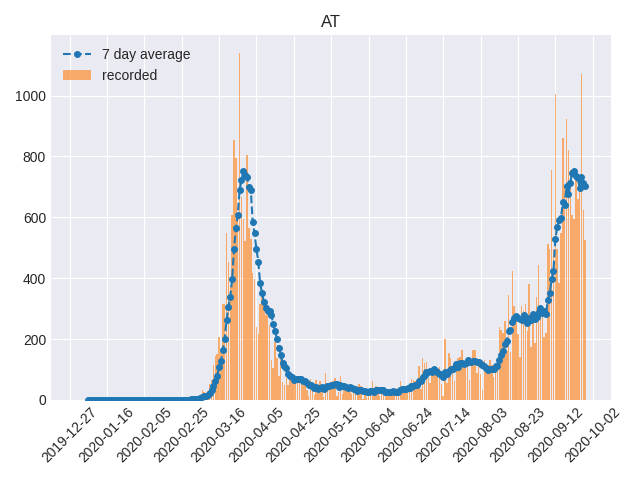

<IPython.core.display.Javascript object>


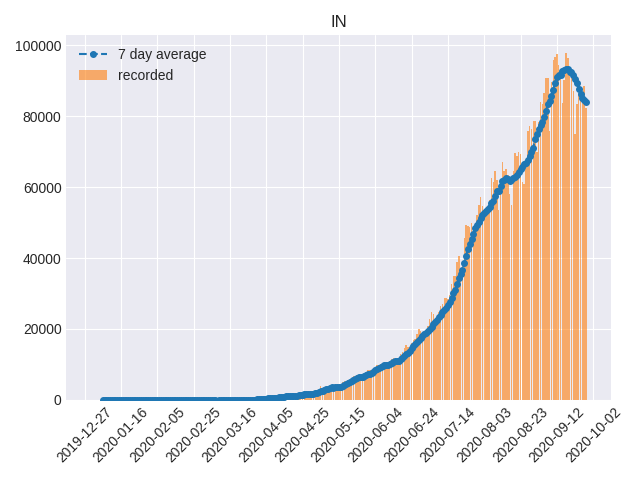

<IPython.core.display.Javascript object>


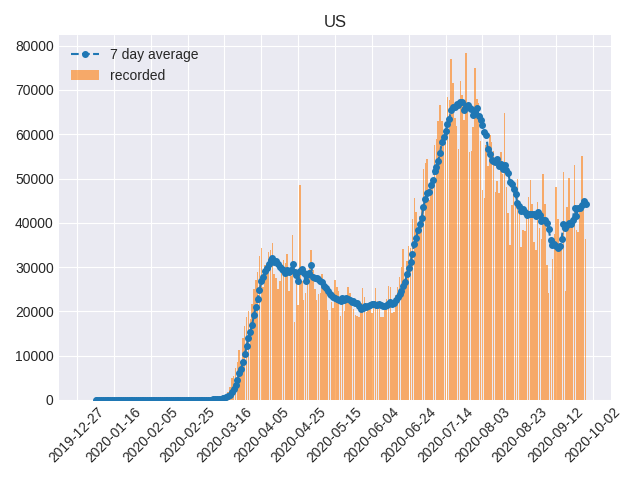

<IPython.core.display.Javascript object>


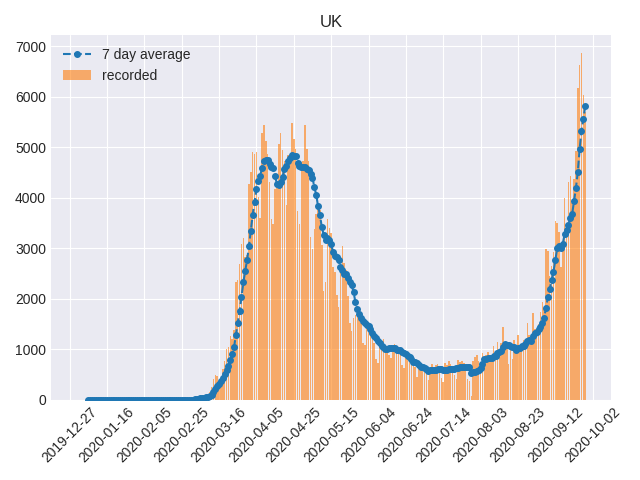

<IPython.core.display.Javascript object>


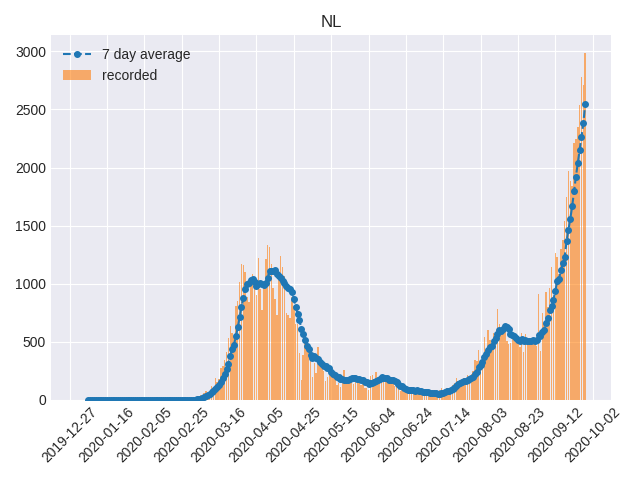

In [32]:
for country in selected_countries:
    f = plot_country(country)
    f.gca().set_title(country)

## Most cases in the last 7 days

### Europe

In [8]:
overview(EU).head(5)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    538569           84806       12115  11123  16096   
Spain                     716481           76441       10920      0  31428   
Russia                   1151438           48039        6863   7867  11656   
United_Kingdom            434969           40712        5816   5692   6873   
Ukraine                   198634           22956        3279   3130   5863   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
France                   31727             442          63     27  2004   
Spain                    31232             737         105      0  1179   
Russia                   20324             906         129     99   312   
United_Kingdom           41988             211          30     17  1224   
Ukraine                   3959             402          57     56   129   

                           dateRep             
                               min        max  
countriesAndTerritories                        
France                  2019-12-31 2020-09-28  
Spain                   2019-12-31 2020-09-27  
Russia                  2019-12-31 2020-09-28  
United_Kingdom          2019-12-31 2020-09-28  
Ukraine                 2020-03-04 2020-09-28

### America

In [9]:
overview(AMERICA).head(5)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
United_States_of_America  7115046          310232       44319  36248  78427   
Brazil                    4732309          187680       26811  14318  69074   
Argentina                  711312           88391       12627   8841  17213   
Colombia                   813056           47980        6854   7018  13056   
Peru                       805302           36407        5201   5160  10143   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
United_States_of_America  204756            5247         750    259  4928   
Brazil                    141741            4846         692    335  1595   
Argentina                  15749            2840         406    206   573   
Colombia                   25488            1280         183    192   400   
Peru                       32262             893         128    120  3935   

                            dateRep             
                                min        max  
countriesAndTerritories                         
United_States_of_America 2019-12-31 2020-09-28  
Brazil                   2019-12-31 2020-09-28  
Argentina                2020-03-04 2020-09-28  
Colombia                 2020-03-07 2020-09-28  
Peru                     2020-03-07 2020-09-28

### World

In [10]:
overview(df).head(10)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6074702          587122       83875  82170  97894   
United_States_of_America  7115046          310232       44319  36248  78427   
Brazil                    4732309          187680       26811  14318  69074   
Argentina                  711312           88391       12627   8841  17213   
France                     538569           84806       12115  11123  16096   
Spain                      716481           76441       10920      0  31428   
Russia                    1151438           48039        6863   7867  11656   
Colombia                   813056           47980        6854   7018  13056   
Israel                     231026           42599        6086   3926  11827   
Indonesia                  285599           40923        5846  14260  14260   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      95542            7660        1094   1039  2003   
United_States_of_America  204756            5247         750    259  4928   
Brazil                    141741            4846         692    335  1595   
Argentina                  15749            2840         406    206   573   
France                     31727             442          63     27  2004   
Spain                      31232             737         105      0  1179   
Russia                     20324             906         129     99   312   
Colombia                   25488            1280         183    192   400   
Israel                      1466             210          30     25    71   
Indonesia                  10386             833         119     78   160   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-09-28  
United_States_of_America 2019-12-31 2020-09-28  
Brazil                   2019-12-31 2020-09-28  
Argentina                2020-03-04 2020-09-28  
France                   2019-12-31 2020-09-28  
Spain                    2019-12-31 2020-09-27  
Russia                   2019-12-31 2020-09-28  
Colombia                 2020-03-07 2020-09-28  
Israel                   2019-12-31 2020-09-28  
Indonesia                2019-12-31 2020-09-28

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [11]:
overview(EU[EU.popData2019>1*10**6]).tail(5)

cases                                         deaths  \
                           sum last_7_days_sum rolling_avg latest  max    sum   
countriesAndTerritories                                                         
Lithuania                 4385             641          92     90  138     91   
Serbia                   33384             476          68     72  467    747   
Kosovo                   15472             409          58     47  496    622   
Estonia                   3200             276          39     35  134     64   
Latvia                    1676             151          22     22   71     36   

                                                                  dateRep  \
                        last_7_days_sum rolling_avg latest max        min   
countriesAndTerritories                                                     
Lithuania                             4           1      2   6 2019-12-31   
Serbia                                6           1      1  18 2020-03-07   
Kosovo                                9           1      3  40 2020-03-14   
Estonia                               0           0      0   6 2019-12-31   
Latvia                                0           0      0   4 2020-03-03   

                                    
                               max  
countriesAndTerritories             
Lithuania               2020-09-28  
Serbia                  2020-09-28  
Kosovo                  2020-09-28  
Estonia                 2020-09-28  
Latvia                  2020-09-28

### America*

\*among countries with population of at least 10 million

In [12]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Guatemala                 90092            4648         664    390  4233   
Bolivia                  133901            3225         461    309  2687   
Dominican_Republic       111386            3097         442    429  2147   
Cuba                       5457             366          52     45    93   
Haiti                      8723             104          15      0   284   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Guatemala                 3229             110          16     16    74   
Bolivia                   7858             241          34     30  1610   
Dominican_Republic        2095              48           7      2    39   
Cuba                       122               7           1      2     6   
Haiti                      227               6           1      0    12   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Guatemala               2020-03-15 2020-09-28  
Bolivia                 2020-03-12 2020-09-28  
Dominican_Republic      2019-12-31 2020-09-28  
Cuba                    2020-03-12 2020-09-28  
Haiti                   2020-03-20 2020-09-28

### World*
\*among countries with population of at least 10 million

In [13]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                          \
                              sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                     
Vietnam                      1074               6           1      5   50   
Yemen                        2034               4           1      1  116   
Taiwan                        510               1           0      0   31   
Cambodia                      276               1           0      0   35   
United_Republic_of_Tanzania   509               0           0      0  174   

                            deaths                                         \
                               sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                     
Vietnam                         35               0           0      0   4   
Yemen                          588               2           0      0  52   
Taiwan                           7               0           0      0   3   
Cambodia                         0               0           0      0   0   
United_Republic_of_Tanzania     21               0           0      0   6   

                               dateRep             
                                   min        max  
countriesAndTerritories                            
Vietnam                     2019-12-31 2020-09-28  
Yemen                       2020-04-10 2020-09-28  
Taiwan                      2019-12-31 2020-09-28  
Cambodia                    2019-12-31 2020-09-28  
United_Republic_of_Tanzania 2020-03-17 2020-09-28

# Austria
Compare ECDC data with Gesundheitsminesterium Data

Index(['time', 'tägliche Erkrankungen', 'Timestamp'], dtype='object')


<IPython.core.display.Javascript object>


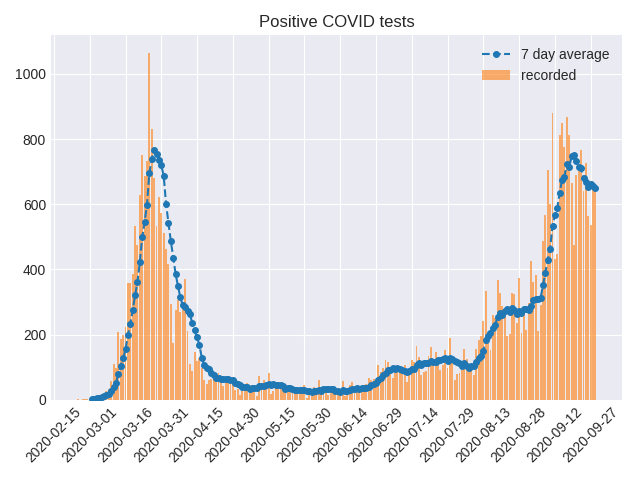

<IPython.core.display.Javascript object>


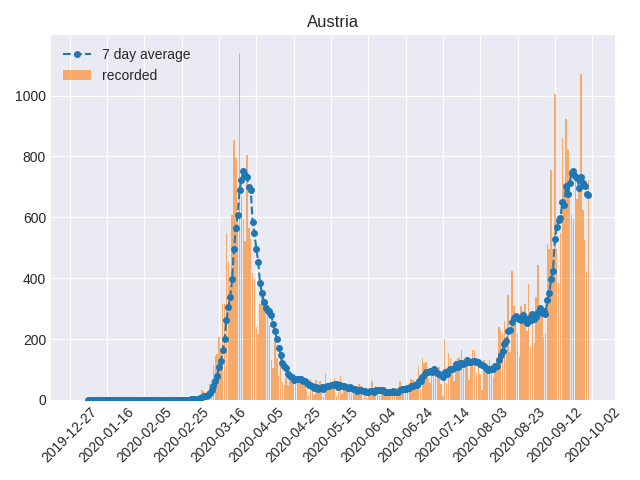

In [10]:
plot_Austria();
plot_country('AT');

### Weekday bias

<IPython.core.display.Javascript object>


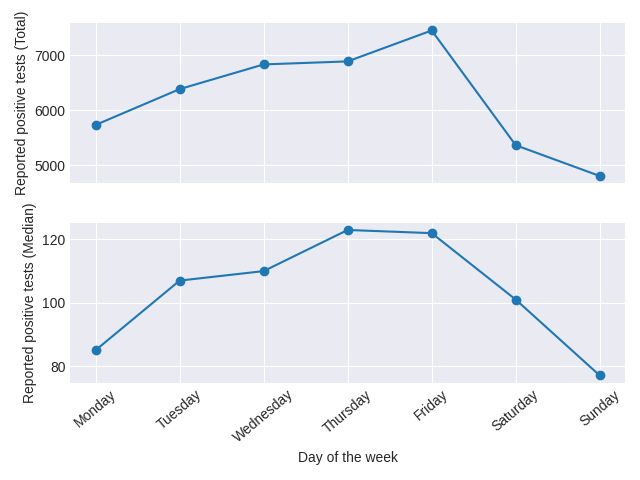

In [16]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


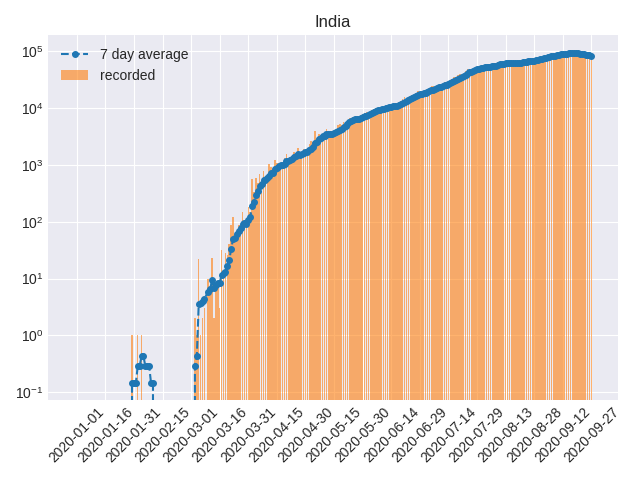

In [62]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


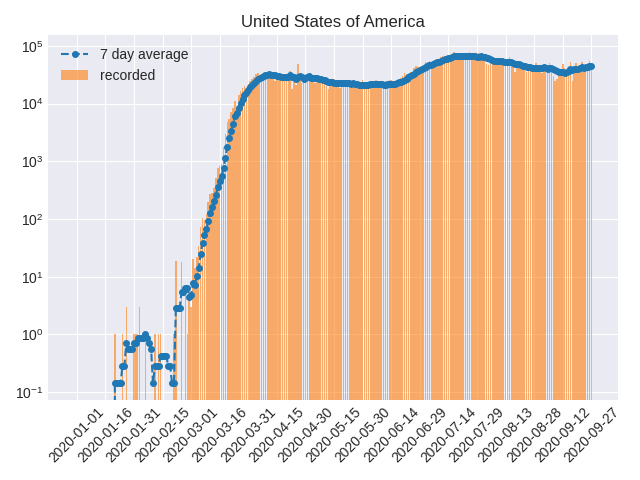

In [63]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


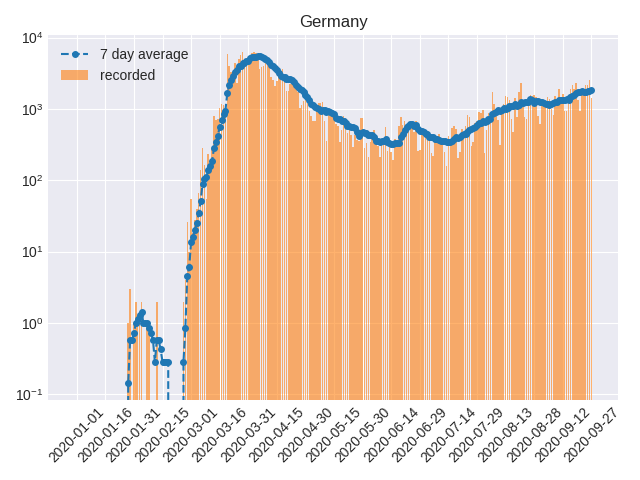

In [64]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


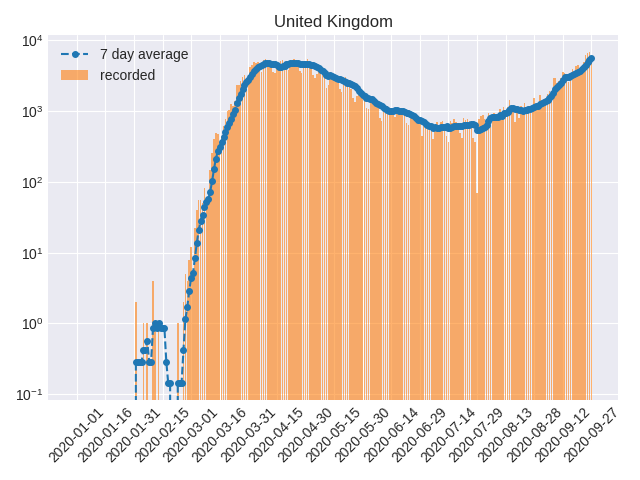

In [65]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


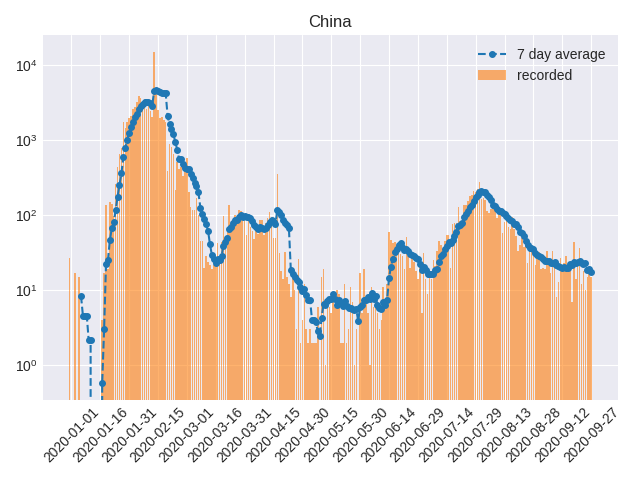

In [66]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [67]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[develop 5fcf30e] Last run on 2020-09-28 10:26
 3 files changed, 2522 insertions(+), 195 deletions(-)
 create mode 100644 notebooks/.ipynb_checkpoints/Austria_ECDC Data Differences-checkpoint.ipynb
 create mode 100644 notebooks/Austria_ECDC Data Differences.ipynb
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 476.99 KiB | 5.55 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:gythaogg/covid19.git
   e8ef7d5..5fcf30e  develop -> develop
